In [1]:
using Revise
using PseudoArcLengthContinuation, LinearAlgebra, Plots, SparseArrays;
const Cont = PseudoArcLengthContinuation


┌ Info: Recompiling stale cache file /Users/rveltz/.julia/compiled/v1.0/PseudoArcLengthContinuation/AGFl5.ji for PseudoArcLengthContinuation [d0d06edc-f53a-11e8-3659-f1b236457aaf]
└ @ Base loading.jl:1190
┌ Warning: Package PseudoArcLengthContinuation does not have LinearMaps in its dependencies:
│ - If you have PseudoArcLengthContinuation checked out for development and have
│   added LinearMaps as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with PseudoArcLengthContinuation
└ Loading LinearMaps into PseudoArcLengthContinuation from project dependency, future warnings for PseudoArcLengthContinuation are suppressed.
┌ Warning: Replacing docs for `PseudoArcLengthContinuation.Default :: Union{}` in module `PseudoArcLengthContinuation`
└ @ Base.Docs docs/Docs.jl:223
┌ Warning: Replacing docs for `PseudoArcLengthContinuation.Default :: Union{}` in module `PseudoArcLengthContinuation`
└ @ Ba

PseudoArcLengthContinuation

In [2]:

f1(u, v) = u^2*v

function F_bru(x, α, β; D1 = 0.008, D2 = 0.004, l = 1.0)
	n = div(length(x), 2)
	h = 1.0 / (n+1); h2 = h*h

	u = @view x[1:n]
	v = @view x[n+1:2n]

	# output
	f = similar(x)

	f[1] = u[1] - α
	f[n] = u[n] - α
	for i=2:n-1
		f[i] = D1/l^2 * (u[i-1] - 2u[i] + u[i+1]) / h2 - (β + 1) * u[i] + α + f1(u[i], v[i])
	end


	f[n+1] = v[1] - β / α
	f[end] = v[n] - β / α;
	for i=2:n-1
		f[n+i] = D2/l^2 * (v[i-1] - 2v[i] + v[i+1]) / h2 + β * u[i] - f1(u[i], v[i])
	end

	return f
end

function Jac_mat(x, α, β; D1 = 0.008, D2 = 0.004, l = 1.0)
	n = div(length(x), 2)
	h = 1.0 / (n+1); hh = h*h

	J = zeros(2n, 2n)

	J[1, 1] = 1.0
	for i=2:n-1
		J[i, i-1] = D1 / hh/l^2
		J[i, i]   = -2D1 / hh/l^2 - (β + 1) + 2x[i] * x[i+n]
		J[i, i+1] = D1 / hh/l^2
		J[i, i+n] = x[i]^2
	end
	J[n, n] = 1.0

	J[n+1, n+1] = 1.0
	for i=n+2:2n-1
		J[i, i-n] = β - 2x[i-n] * x[i]
		J[i, i-1] = D2 / hh/l^2
		J[i, i]   = -2D2 / hh/l^2 - x[i-n]^2
		J[i, i+1] = D2 / hh/l^2
	end
	J[2n, 2n] = 1.0
	return J
end

function Jac_sp(x, α, β; D1 = 0.008, D2 = 0.004, l = 1.0)
	# compute the Jacobian using a sparse representation
	n = div(length(x), 2)
	h = 1.0 / (n+1); hh = h*h

	diag  = zeros(2n)
	diagp1 = zeros(2n-1)
	diagm1 = zeros(2n-1)

	diagpn = zeros(n)
	diagmn = zeros(n)

	diag[1] = 1.0
	diag[n] = 1.0
	diag[n + 1] = 1.0
	diag[end] = 1.0

	for i=2:n-1
		diagm1[i-1] = D1 / hh/l^2
		diag[i]   = -2D1 / hh/l^2 - (β + 1) + 2x[i] * x[i+n]
		diagp1[i] = D1 / hh/l^2
		diagpn[i] = x[i]^2
	end

	for i=n+2:2n-1
		diagmn[i-n] = β - 2x[i-n] * x[i]
		diagm1[i-1] = D2 / hh/l^2
		diag[i]   = -2D2 / hh/l^2 - x[i-n]^2
		diagp1[i] = D2 / hh/l^2
	end
	return spdiagm(0 => diag, 1 => diagp1, -1 => diagm1, n => diagpn, -n => diagmn)
end



function finalise_solution(z, tau, step, contResult)
	n = div(length(z), 2)
	printstyled(color=:red, "--> Solution constante = ", norm(diff(z[1:n])), " - ", norm(diff(z[n+1:2n])), "\n")
end

finalise_solution (generic function with 1 method)

In [33]:
n = 101
# const Δ = spdiagm(0=>2ones(N), -1=>0ones(N-1), 1=>-ones(N-1))
Jac_fd(u0, α, β, l = l) = Cont.finiteDifferences(u->F_bru(u, α, β, l=l), u0)

a = 2.
b = 5.45
sol0 = vcat(a*ones(n), b/a*ones(n))

opt_newton = Cont.NewtonPar(tol = 1e-11, verbose = true)
	# ca fait dans les 60.2k Allocations
	out, hist, flag = @time Cont.newton(
		x -> F_bru(x, a, b),
		x -> Jac_mat(x, a, b),
		sol0,
		opt_newton)


 Start Newton-GMRES Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     0.0000e+00         0
  0.048414 seconds (60.91 k allocations: 2.799 MiB)


([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725], [0.0], true, 0)

┌ Warning: Should use immutable
└ @ PseudoArcLengthContinuation /Users/rveltz/work/prog_gd/julia/dev/PseudoArcLengthContinuation.jl/src/Newton.jl:73


##################################################
*********** ArcLengthContinuationNewton *************

*********** CONVERGE INITIAL GUESS *************
--> convergence of initial guess = OK
--> p = 0.3, initial step
--> Solution constante = 0.0 - 0.0

*********** COMPUTING TANGENTS *************

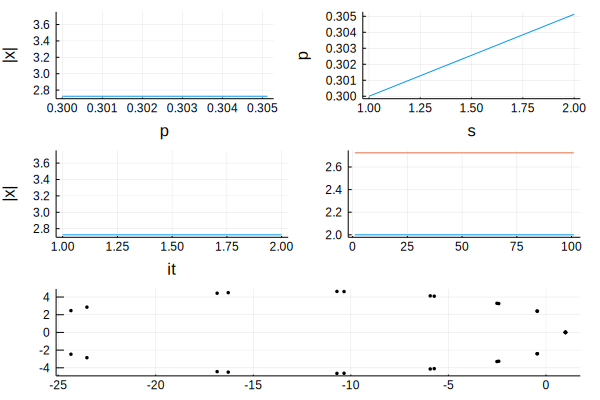


--> convergence of initial guess = OK

--> p = 0.300102, initial step (bis)
--> Solution constante = 0.0 - 0.0
α = 0.99498743710662
--> Start continuation from p = 0.3
########################################################################
Start of Continuation Step 0 : Parameter: p1 = 3.0513e-01 from 3.0000e-01
--> Step Converged in 0 Nonlinear Solver Iterations!
--> predictor = Secant
--> Solution constante = 0.0 - 0.0
1 + contparams.a * factor ^ 2 = 1.5
########################################################################
Start of Continuation Step 1 : Parameter: p1 = 3.1126e-01 from 3.0513e-01
Current step size  = 6.1000e-03   Previous step size = 5.1000e-03
--> Step Converged in 0 Nonlinear Solver Iterations!
--> predictor = Secant
--> Solution constante = 0.0 - 0.0
1 + contparams.a * factor ^ 2 = 1.5
########################################################################
Start of Continuation Step 2 : Parameter: p1 = 3.1739e-01 from 3.1126e-01
Current step size  = 6.1000e-0

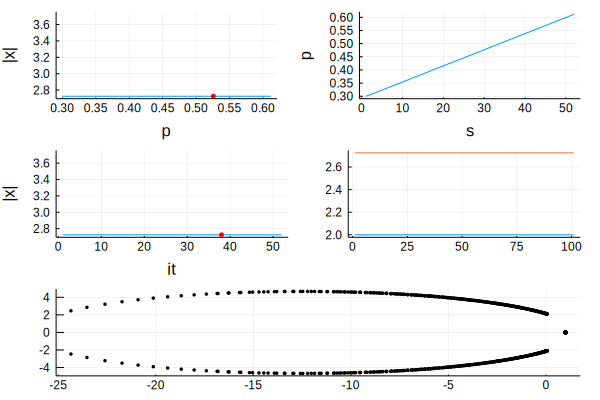

1 + contparams.a * factor ^ 2 = 1.5
########################################################################
Start of Continuation Step 48 : Parameter: p1 = 5.9940e-01 from 5.9327e-01
Current step size  = 6.1000e-03   Previous step size = 6.1000e-03
--> Step Converged in 0 Nonlinear Solver Iterations!
--> predictor = Secant
--> Solution constante = 0.0 - 0.0
1 + contparams.a * factor ^ 2 = 1.5
########################################################################
Start of Continuation Step 49 : Parameter: p1 = 6.0553e-01 from 5.9940e-01
Current step size  = 6.1000e-03   Previous step size = 6.1000e-03
--> Step Converged in 0 Nonlinear Solver Iterations!
--> predictor = Secant
--> Solution constante = 0.0 - 0.0
1 + contparams.a * factor ^ 2 = 1.5
########################################################################
Start of Continuation Step 50 : Parameter: p1 = 6.1166e-01 from 6.0553e-01
Current step size  = 6.1000e-03   Previous step size = 6.1000e-03
--> Step Converged in 0 Nonl

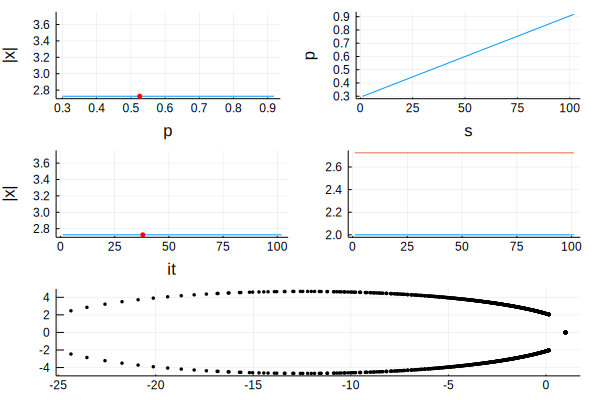

1 + contparams.a * factor ^ 2 = 1.5
########################################################################
Start of Continuation Step 98 : Parameter: p1 = 9.0594e-01 from 8.9981e-01
Current step size  = 6.1000e-03   Previous step size = 6.1000e-03
--> Step Converged in 0 Nonlinear Solver Iterations!
--> predictor = Secant
--> Solution constante = 0.0 - 0.0
1 + contparams.a * factor ^ 2 = 1.5
########################################################################
Start of Continuation Step 99 : Parameter: p1 = 9.1207e-01 from 9.0594e-01
Current step size  = 6.1000e-03   Previous step size = 6.1000e-03
--> Step Converged in 0 Nonlinear Solver Iterations!
--> predictor = Secant
--> Solution constante = 0.0 - 0.0
1 + contparams.a * factor ^ 2 = 1.5
########################################################################
Start of Continuation Step 100 : Parameter: p1 = 9.1820e-01 from 9.1207e-01
Current step size  = 6.1000e-03   Previous step size = 6.1000e-03
--> Step Converged in 0 Non

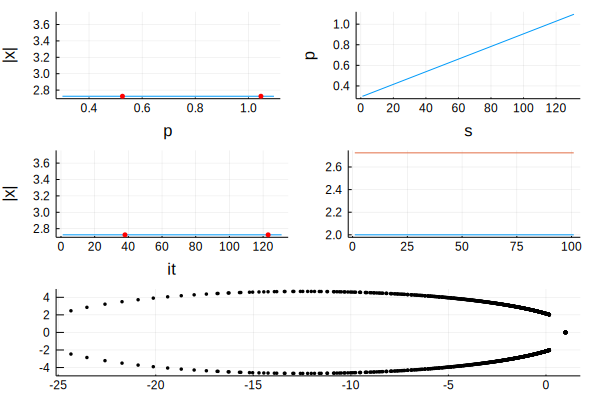

1 + contparams.a * factor ^ 2 = 1.5
########################################################################
Start of Continuation Step 128 : Parameter: p1 = 1.0899e+00 from 1.0837e+00
Current step size  = 6.1000e-03   Previous step size = 6.1000e-03
--> Step Converged in 0 Nonlinear Solver Iterations!
--> predictor = Secant
--> Solution constante = 0.0 - 0.0
1 + contparams.a * factor ^ 2 = 1.5
########################################################################
Start of Continuation Step 129 : Parameter: p1 = 1.0960e+00 from 1.0899e+00
Current step size  = 6.1000e-03   Previous step size = 6.1000e-03
--> Step Converged in 0 Nonlinear Solver Iterations!
--> predictor = Secant
--> Solution constante = 0.0 - 0.0
1 + contparams.a * factor ^ 2 = 1.5
  6.662096 seconds (6.94 M allocations: 546.650 MiB, 2.11% gc time)


(PseudoArcLengthContinuation.ContResult{Float64,Array{Float64,1}}
  branch: RecursiveArrayTools.VectorOfArray{Float64,2,Array{Array{Float64,1},1}}
  eig: Array{Tuple{Array{Complex{Float64},1},Array{Complex{Float64},2}}}((131,))
  bifpoint: Array{Tuple{Symbol,Int64,Float64,Float64,Array{Float64,1},Array{Float64,1},Int64}}((2,))
  stability: Array{Bool}((131,)) Bool[false, false, false, false, false, false, false, false, false, false  …  false, false, false, false, false, false, false, false, false, false]
  n_imag: Array{Int64}((131,)) [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  2, 2, 4, 4, 4, 4, 4, 4, 4, 4]
  n_unstable: Array{Int64}((131,)) [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  6, 6, 8, 8, 8, 8, 8, 8, 8, 8]
, PseudoArcLengthContinuation.BorderedVector{Array{Float64,1},Float64}([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725], 1.0959899496852972), PseudoArcLengthContinuation.BorderedVector{Array{Float64,1},Float64}([0.0, 0.0,

In [34]:
opts_br0 = ContinuationPar(dsmin = 0.001, dsmax = 0.0061, ds= 0.0051, pMax = 1.2, save = false, theta = 0.01, detect_fold = true, detect_bifurcation = true, nev = 16, plot_every_n_steps = 50)
	opts_br0.newtonOptions.maxIter = 20
	opts_br0.newtonOptions.tol = 1e-8
	opts_br0.maxSteps = 130

	br, u1 = @time Cont.continuation(
		(x, p) ->   F_bru(x, a, b, l = p),
		(x, p) -> Jac_mat(x, a, b, l = p),
		out,
		0.3,
		opts_br0,
		plot = true,
		plotsolution = (x;kwargs...)->(N = div(length(x), 2);plot!(x[1:N], subplot=4, label="");plot!(x[N+1:2N], subplot=4, label="")),
		finaliseSolution = finalise_solution,
		printsolution = x->norm(x, Inf64))


On affine la bifurcation de Hopf trouvee dans la cellule precedente

In [35]:
ind_hopf = 1
	hopfpt = Cont.HopfPoint(br, ind_hopf)

	outhopf, hist, flag = @time Cont.newtonHopf((x, p) ->  F_bru(x, a, b, l = p),
                (x, p) -> Jac_mat(x, a, b, l = p),
				br, ind_hopf,
				NewtonPar(verbose = true))
	flag && printstyled(color=:red, "--> We found a Hopf Point at l = ", outhopf[end-1], ", ω = ", outhopf[end], "\n")



 Start Newton-GMRES Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     2.4633e-03         0
        1                2     2.1644e-03         2
        2                3     1.6700e-04         2
        3                4     1.1538e-05         2
        4                5     8.0409e-07         2
        5                6     5.6005e-08         2
        6                7     3.9009e-09         2
        7                8     2.7179e-10         2
        8                9     1.8959e-11         2
  0.987379 seconds (127.46 k allocations: 1.087 GiB, 20.78% gc time)
--> We found a Hopf Point at l = 0.5232588119320821, ω = -2.1395092895494887


┌ Warning: WIP Hopf Normal Form not computed yet!
└ @ PseudoArcLengthContinuation /Users/rveltz/work/prog_gd/julia/dev/PseudoArcLengthContinuation.jl/src/HopfCont.jl:233


┌ Warning: Should use immutable
└ @ PseudoArcLengthContinuation /Users/rveltz/work/prog_gd/julia/dev/PseudoArcLengthContinuation.jl/src/Newton.jl:73
┌ Warning: Bad way it create a struct for every p2
└ @ PseudoArcLengthContinuation /Users/rveltz/work/prog_gd/julia/dev/PseudoArcLengthContinuation.jl/src/HopfCont.jl:251


##################################################
*********** ArcLengthContinuationNewton *************

*********** CONVERGE INITIAL GUESS *************
--> convergence of initial guess = OK
--> p = 10.2, initial step

*********** COMPUTING TANGENTS *************
--> convergence of initial guess = 

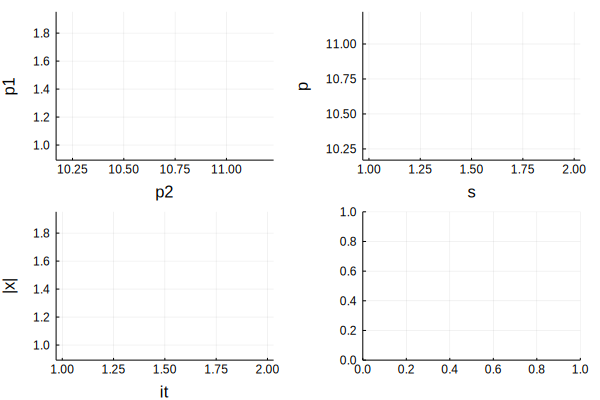

OK

--> p = 10.200019999999999, initial step (bis)
α = 0.00014075109513957582
--> Start continuation from p = 10.2
  6.311430 seconds (10.52 M allocations: 3.807 GiB, 14.61% gc time)


(PseudoArcLengthContinuation.ContResult{Float64,Array{Float64,1}}
  branch: RecursiveArrayTools.VectorOfArray{Float64,2,Array{Array{Float64,1},1}}
  eig: Array{Tuple{Array{Complex{Float64},1},Array{Complex{Float64},2}}}((1,))
  bifpoint: Array{Tuple{Symbol,Int64,Float64,Float64,Array{Float64,1},Array{Float64,1},Int64}}((0,))
  stability: Array{Bool}((1,)) Bool[false]
  n_imag: Array{Int64}((1,)) [0]
  n_unstable: Array{Int64}((1,)) [0]
, PseudoArcLengthContinuation.BorderedVector{Array{Float64,1},Float64}([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  5.10001, 5.10001, 5.10001, 5.10001, 5.10001, 5.10001, 5.10001, 5.10001, 0.922245, -2.81583], 10.2), PseudoArcLengthContinuation.BorderedVector{Array{Float64,1},Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.42095, 1.42095, 1.42095, 1.42095, 1.42095, 1.42095, 1.42095, 1.42095, -0.252011, -0.0897157], 7104.740456963053))

In [6]:
br_hopf, u1_hopf = @time Cont.continuationHopf(
			(x, p, β) ->   F_bru(x, a, β, l = p),
			(x, p, β) -> Jac_mat(x, a, β, l = p),
			br, ind_hopf,
			b,
			ContinuationPar())


On essaie de trouver une orbite periodique proche de la bifurcation de Hopf

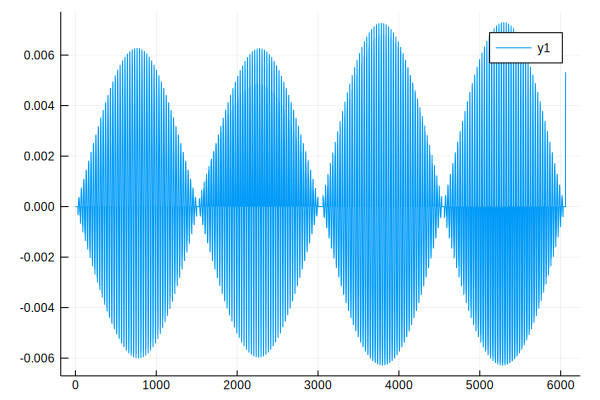

In [36]:
ind_hopf = 2
hopfpt = Cont.HopfPoint(br, ind_hopf)

l_hopf = hopfpt[end-1]
ωH     = hopfpt[end-2]

M = 30

orbitguess = zeros(M, 2n)
plot([0, 1], [0, 0])
	tt = []; phase = []
	vec_hopf = br.eig[br.bifpoint[ind_hopf][2]][2][:, br.bifpoint[ind_hopf][end]-1]
	for ii=1:M
	t = (ii-1)/(M-1)
	orbitguess[ii, :] .= real.(hopfpt[1:2n] +
						12*0.1 * vec_hopf * exp(2pi * complex(0, 1) * (t - 0.2790)))
	push!(tt, t);push!(phase, dot(orbitguess[ii, :]- hopfpt[1:2n], real.(vec_hopf)))
end
	plot!(tt, phase)
orbitguess_f = vcat(vec(orbitguess), 2pi/ωH) |> vec

poTrap = l-> PeriodicOrbitTrap(
			x-> F_bru(x, a, b, l = l),
			x-> Jac_sp(x, a, b, l = l),
			real.(vec_hopf),
			hopfpt[1:2n],
			M,
			opt_newton.linsolve,
			opt_newton)

poTrap(l_hopf + 0.01)(orbitguess_f) |> plot


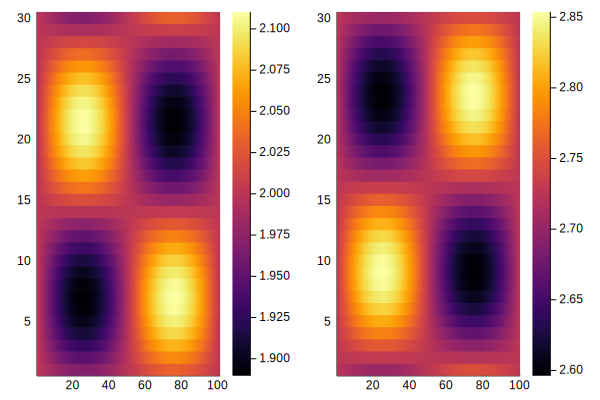

In [37]:
plot(heatmap(orbitguess[:,1:n]),heatmap(orbitguess[:,n+2:end]))


 Start Newton-GMRES Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     2.4648e-01         0
        1                2     3.0944e-01         1
        2                3     3.7254e-02         1
        3                4     4.3003e-03         1
        4                5     1.2634e-05         1
        5                6     1.0064e-09         1
 22.053377 seconds (41.99 M allocations: 32.949 GiB, 23.87% gc time)
--> T = 3.060433835292789


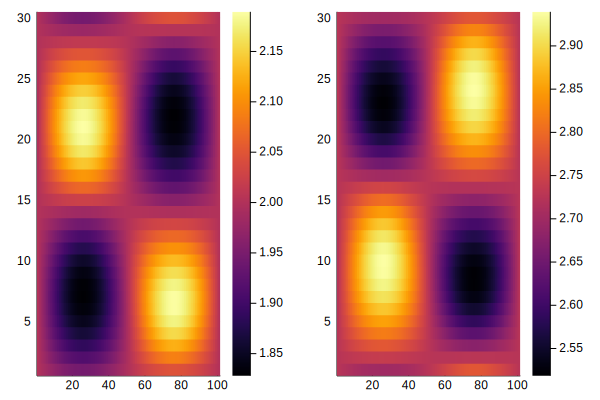

In [43]:
opt_po = Cont.NewtonPar(tol = 1e-8, verbose = true, maxIter = 50)
	outpo, hist, flag = @time Cont.newton(
						x ->  poTrap(l_hopf + 0.01)(x),
						# x -> Jac_orbit(x, periodicOrbitPb),
						orbitguess_f,
						opt_po)
	println("--> T = ", outpo[end])
plot(heatmap(reshape(outpo[1:end-1], M, 2n)[:,1:n]),heatmap(reshape(outpo[1:end-1], M, 2n)[:,n+1:end]))

typeof(on.linsolve) = Default
##################################################
*********** ArcLengthContinuationNewton *************

*********** CONVERGE INITIAL GUESS *************
 Start Newton-GMRES Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     1.0064e-09         0
        1                2     8.3806e-14         1

--> convergence of initial guess = OK
--> p = 1.0569441043006482, initial step

*********** COMPUTING TANGENTS *************
 Start Newton-GMRES Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     3.1976e-05         0
        1                2     4.0407e-06         1
        2                3     2.0337e-10         1
        3                4     8.6958e-14         1

--> convergence of initial guess = OK

--> p = 1.0570441043006482, initial step (bis)
α = 0.9486834689454735
--> Start continuation from p = 1.0569441043006482
########################

┌ Warning: Should use immutable
└ @ PseudoArcLengthContinuation /Users/rveltz/work/prog_gd/julia/dev/PseudoArcLengthContinuation.jl/src/Newton.jl:73


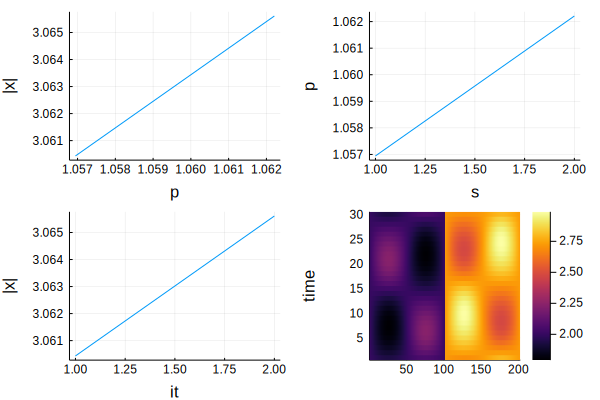

        5                1     1.2877e-13 (     1,      1)
--> Step Converged in 5 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.405
########################################################################
Start of Continuation Step 1 : Parameter: p1 = 1.0667e+00 from 1.0622e+00
Current step size  = 7.0250e-03   Previous step size = 5.0000e-03

 Start Newton-GMRES Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     1.3591e-02         0
        1                1     2.7333e-05 (     1,      1)
        2                1     9.8091e-09 (     1,      1)
        3                1     1.0474e-13 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 2 : Parameter: p1 = 1.0742e+00 from 1.0671e+00
Current step size  = 1.012

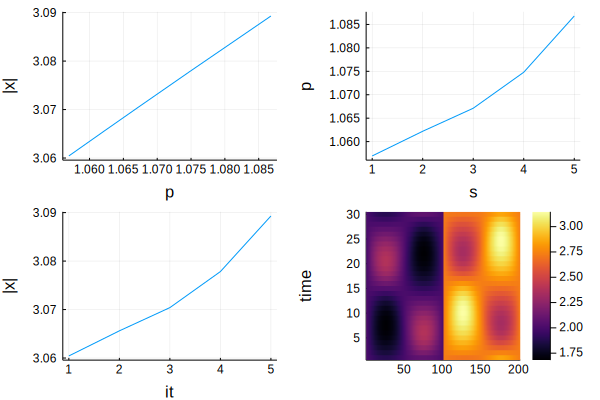

        3                1     2.1220e-12 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 4 : Parameter: p1 = 1.1040e+00 from 1.0868e+00
Current step size  = 2.1055e-02   Previous step size = 1.0129e-02

 Start Newton-GMRES Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     6.4081e-02         0
        1                1     6.5351e-04 (     1,      1)
        2                1     2.3794e-06 (     1,      1)
        3                1     1.2692e-11 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 5 : Parameter: p1 = 1.1320e+00 from 1.1054e+00
Current step size  = 3.03

InterruptException: InterruptException:

In [44]:
opts_po_cont = ContinuationPar(dsmin = 0.001, dsmax = 0.1, ds= 0.005, pMax = 4.5, maxSteps = 400, secant = true, theta=0.1, plot_every_n_steps = 3, newtonOptions = NewtonPar(verbose=true))
	br_pok1, _ , _= @time Cont.continuation(
							(x, p) ->  poTrap(p)(x),
							# (x, p) -> (v-> poTrap(p)(x, v)),
							outpo, l_hopf + 0.01,
							opts_po_cont, plot = true, plotsolution = (x;kwargs...)->heatmap!(reshape(x[1:end-1], M, 2*n), subplot=4, ylabel="time"),
							printsolution = u -> u[end])